In [1]:
from scipy.stats import ttest_ind
import helper 
import xarray as xr 
import numpy as np 
import cmaps as cmap 
import matplotlib.pyplot as plt
import scipy 
import warnings
import matplotlib.patheffects as pe
from matplotlib.colors import Normalize
from matplotlib import rcParams
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.patches import Rectangle
import matplotlib.patheffects as pe
warnings.filterwarnings("ignore")

def rePoPolar(dataset, name, offset):
    x = dataset.lon.values / 4
    y = dataset.lat.values / 4
    x, y = np.meshgrid(x, y)

    R = 6371.0
    cphi = np.cos(np.deg2rad(y))
    x = R * np.deg2rad(x) * cphi
    y = R * np.deg2rad(y)

    r = np.sqrt(x**2 + y**2)
    t = np.arctan2(y, x)

    rBins = np.linspace(np.nanmin(r), np.nanmax(r), 120)
    tBins = np.linspace(np.nanmin(t), np.nanmax(t), 360)

    for i in range(len(tBins)):
            tBins[i] = tBins[i] + offset
            while tBins[i] <= (-1 * np.pi):
                tBins[i] = tBins[i] + (2 * np.pi)
            while tBins[i] >= np.pi:
                tBins[i] = tBins[i] - (2 * np.pi)

    R, T = np.meshgrid(rBins, tBins)
    newX, newY = R * np.cos(T), R * np.sin(T)
    gridded_data = scipy.interpolate.griddata((x.flatten(), y.flatten()), dataset.values.flatten(), (newX.flatten(), newY.flatten()), method='nearest')

    polar = xr.Dataset(
        {
            name: (('r', 'theta'), gridded_data.reshape(R.shape).transpose())
        },
        coords={
            'r': rBins,
            'theta': tBins
        }
    )

    return polar


In [2]:
dataset = xr.open_dataset(r"C:\Users\deela\Downloads\TCRADAR_ERA5.nc")
print(dataset)
print(list(dataset.variables))

<xarray.Dataset> Size: 13GB
Dimensions:      (case: 1510, level: 17, lon: 121, lat: 121)
Coordinates:
  * level        (level) int16 34B 200 250 300 350 400 ... 800 850 900 950 1000
  * case         (case) int64 12kB 29 29 29 29 30 ... 3713 3715 3715 3715 3715
  * lon          (lon) int64 968B -60 -59 -58 -57 -56 -55 ... 55 56 57 58 59 60
  * lat          (lat) int64 968B -60 -59 -58 -57 -56 -55 ... 55 56 57 58 59 60
Data variables: (12/28)
    rlhum        (case, level, lon, lat) float32 2GB ...
    sphum        (case, level, lon, lat) float32 2GB ...
    u_data       (case, level, lon, lat) float32 2GB ...
    v_data       (case, level, lon, lat) float32 2GB ...
    temperature  (case, level, lon, lat) float32 2GB ...
    height       (case, level, lon, lat) float32 2GB ...
    ...           ...
    fdelta_vmax  (case) float32 6kB ...
    bdelta_vmax  (case) float32 6kB ...
    system_type  (case) <U2 12kB ...
    uspd         (case) float32 6kB ...
    vspd         (case) float32 6k

In [3]:
def process(data, ddir):
    dataList = []
    print(len(data.case))
    for x in range(len(data.case)):
        # print(x)
        offset = np.deg2rad(360 - ddir.isel(case = x))
        try:
            temp = rePoPolar(data.isel(case = x), 'rh', offset = offset)
        except:
            temp = xr.Dataset(
                {
                    var: (temp[var].dims, np.full_like(temp[var], np.nan))
                    for var in temp.data_vars
                },
                coords=temp.coords,
                attrs=temp.attrs)

        dataList.append(temp)

    newTheta = np.linspace(-np.pi, np.pi, 360, endpoint=False)
    for x in range(len(dataList)):
        try:
            dataList[x] = dataList[x].interp(theta = newTheta)    
            # dataList[x]['rh'].values = np.flip(dataList[x]['rh'].values, axis = 1)
        except:
            pass

    rh = xr.concat(dataList, dim = 'case')
    print(rh)  

    return rh, newTheta 

In [4]:
def labels(ax, flag = False):
    ax.set_theta_zero_location("N")
    ax.set_theta_direction(-1)
    if flag == False:
        ax.text(1 * np.pi / 4, 1000, 'Downshear\nRight', size = 12, color = 'black', horizontalalignment = 'center', fontfamily = 'Courier New', fontweight = 'bold', path_effects=[pe.withStroke(linewidth=2.25, foreground="white")], verticalalignment = 'center')
        ax.text(3 * np.pi / 4, 1000, 'Upshear\nRight', size = 12, color = 'black', horizontalalignment = 'center', fontfamily = 'Courier New', fontweight = 'bold', path_effects=[pe.withStroke(linewidth=2.25, foreground="white")], verticalalignment = 'center')
        ax.text(5 * np.pi / 4, 1000, 'Upshear\nLeft', size = 12, color = 'black', horizontalalignment = 'center', fontfamily = 'Courier New', fontweight = 'bold', path_effects=[pe.withStroke(linewidth=2.25, foreground="white")], verticalalignment = 'center')
        ax.text(7 * np.pi / 4, 1000, 'Downshear\nLeft', size = 12, color = 'black', horizontalalignment = 'center', fontfamily = 'Courier New', fontweight = 'bold', path_effects=[pe.withStroke(linewidth=2.25, foreground="white")], verticalalignment = 'center')
        
        ax.annotate('', xy=(0, 500), xytext=(np.pi, 500),
                arrowprops=dict(facecolor='black', edgecolor='black', width=1, headwidth=8, headlength=10, path_effects=[pe.withStroke(linewidth=2.25, foreground="white")]))

    ax.set_yticklabels(['', '200km', '', '600km', '', '1000km', '', ''], fontfamily = 'Courier New', path_effects=[pe.withStroke(linewidth=2.25, foreground="white")])
    ax.set_xticklabels(['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW'], fontfamily = 'Courier New', path_effects=[pe.withStroke(linewidth=2.25, foreground="white")])


In [5]:
alignment = [225, 251, 252, 253, 254, 333, 334, 347, 374, 376, 377, 407, 408, 409, 410, 413, 414, 603, 604, 605, 672, 712, 719, 752, 765, 864, 878, 879, 939, 941, 957, 968, 969, 970, 971, 1057, 1073, 1101, 1128, 1131, 1148, 1177, 1178, 1179, 1180, 1191, 1192, 1220, 1221, 1222, 1223, 1224, 1226, 1227, 1228, 1302, 1379, 1380, 1391, 1405, 1406, 1445, 1446, 1447, 1448, 1453, 1471]
misalign = [148, 149, 223, 224, 339, 340, 341, 342, 343, 344, 382, 383, 384, 386, 400, 402, 423, 424, 425, 426, 427, 429, 430, 431, 545, 600, 601, 742, 744, 745, 747, 757, 760, 869, 898, 899, 918, 919, 930, 934, 935, 936, 1042, 1052, 1174, 1175, 1195, 1197, 1201, 1217, 1218, 1372, 1373, 1376, 1377, 1408, 1410, 1418, 1419]

In [18]:
hgt = 'Sfc'
var = 'Theta-E'
varShort = 'rh'
height = f'{hgt}'


In [19]:
uData = dataset['ud10'] - dataset['uspd']
vData = dataset['vd10'] - dataset['vspd']
ddir = dataset['shear_dir']

In [20]:
ud = uData#.sel(level = hgt)
u, newTheta = process(ud, ddir)
vd = vData#.sel(level = hgt)
v, newTheta = process(vd, ddir)

1510
<xarray.Dataset> Size: 522MB
Dimensions:  (case: 1510, r: 120, theta: 360)
Coordinates:
  * r        (r) float64 960B 0.0 19.49 38.97 ... 2.28e+03 2.299e+03 2.319e+03
  * theta    (theta) float64 3kB -3.142 -3.124 -3.107 ... 3.089 3.107 3.124
Dimensions without coordinates: case
Data variables:
    rh       (case, r, theta) float64 522MB nan 2.408 2.408 ... 3.581 4.39 5.43
1510
<xarray.Dataset> Size: 522MB
Dimensions:  (case: 1510, r: 120, theta: 360)
Coordinates:
  * r        (r) float64 960B 0.0 19.49 38.97 ... 2.28e+03 2.299e+03 2.319e+03
  * theta    (theta) float64 3kB -3.142 -3.124 -3.107 ... 3.089 3.107 3.124
Dimensions without coordinates: case
Data variables:
    rh       (case, r, theta) float64 522MB nan 8.009 8.009 ... -1.683 -1.395


In [21]:
R, T = np.meshgrid(u.r, newTheta, indexing = 'ij') 
radialWind = (u['rh'] * np.cos(T)) + (v['rh'] * np.sin(T))
radialWind.values = np.flip(radialWind.values, axis = 2)

In [22]:
print(radialWind)

<xarray.DataArray 'rh' (case: 1510, r: 120, theta: 360)> Size: 522MB
array([[[-2.26789147, -2.12705707, -1.98557475, ..., -2.68607919,
         -2.5474451 ,         nan],
        [-8.08011065, -8.31982838, -8.55701182, ..., -7.34648557,
         -7.59336511,         nan],
        [-8.08011065, -8.31982838, -8.55701182, ..., -7.34648557,
         -7.59336511,         nan],
        ...,
        [ 2.63176797,  2.85875794,  2.62734401, ...,  2.85770305,
          2.78716   ,         nan],
        [ 2.63176797,  2.85875794,  2.61929601, ...,  2.85770305,
          2.78716   ,         nan],
        [ 2.63176797,  2.85875794,  2.61929601, ...,  2.85770305,
          2.78716   ,         nan]],

       [[-2.26789147, -2.12705707, -1.98557475, ..., -2.68607919,
         -2.5474451 ,         nan],
        [-8.08011065, -8.31982838, -8.55701182, ..., -7.34648557,
         -7.59336511,         nan],
        [-8.08011065, -8.31982838, -8.55701182, ..., -7.34648557,
         -7.59336511,         nan]

In [23]:
radPer = radialWind - radialWind.mean('theta')

In [24]:
data = helper.thetae(dataset['2mtmp'], dataset['slp'], 1000, dataset['2mdew'], dew = True)
data = data#.sel(level = hgt)

ddir = dataset['shear_dir']
thetaE, newTheta = process(data, ddir)

1510
<xarray.Dataset> Size: 522MB
Dimensions:  (case: 1510, r: 120, theta: 360)
Coordinates:
  * r        (r) float64 960B 0.0 19.49 38.97 ... 2.28e+03 2.299e+03 2.319e+03
  * theta    (theta) float64 3kB -3.142 -3.124 -3.107 ... 3.089 3.107 3.124
Dimensions without coordinates: case
Data variables:
    rh       (case, r, theta) float64 522MB nan 359.1 359.1 ... 307.7 301.7


In [25]:
thetaE['rh'].values = np.flip(thetaE['rh'].values, axis = 2)
thtPer = thetaE['rh'] - thetaE['rh'].mean('theta')

In [26]:
vent = radPer * thtPer
t = f'{height} Ventilation'

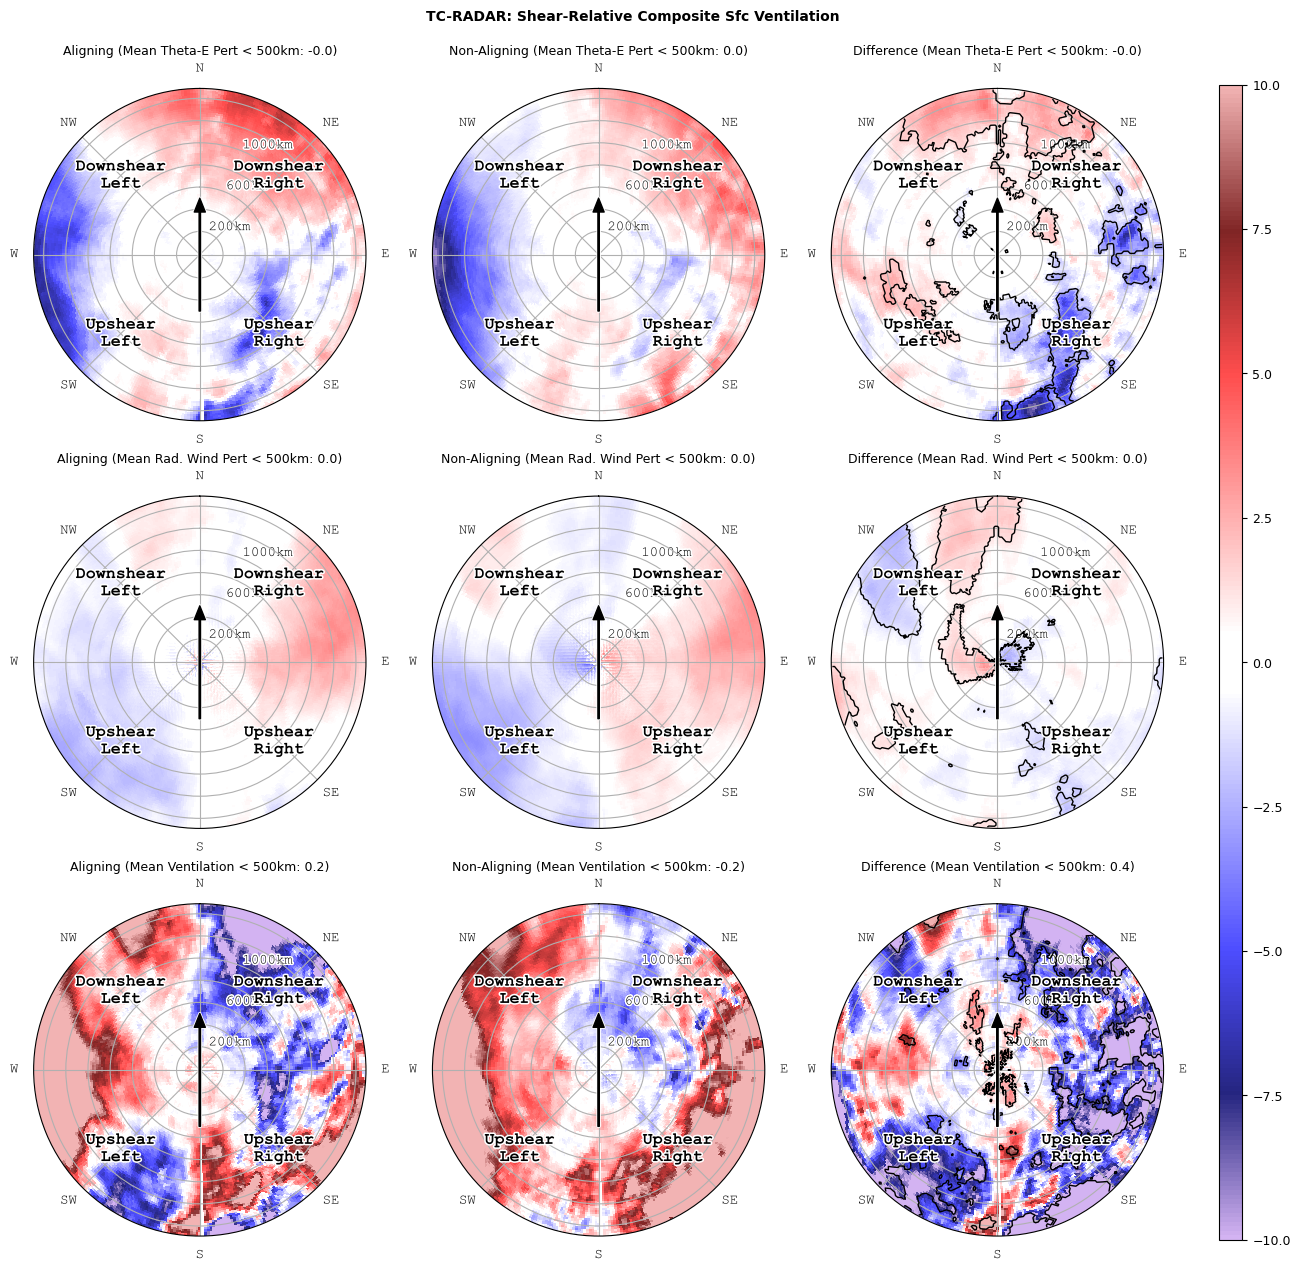

In [27]:
t = f'{height} Ventilation'

thet1 = thtPer.sel(case = alignment, r = slice(0, 1500))
thet2 = thtPer.sel(case = misalign, r = slice(0, 1500))
tstat, pval = ttest_ind(thet1, thet2, axis = 0, equal_var=False, nan_policy='omit')
sigThet = pval < 0.05
thet1 = thet1.mean('case')
thet2 = thet2.mean('case')
thetDiff = thet1 - thet2

radi1 = radPer.sel(case = alignment, r = slice(0, 1500))
radi2 = radPer.sel(case = misalign, r = slice(0, 1500))
tstat, pval = ttest_ind(radi1, radi2, axis = 0, equal_var=False, nan_policy='omit')
sigRadi = pval < 0.05
radi1 = radi1.mean('case')
radi2 = radi2.mean('case')
radiDiff = radi1 - radi2

vent1 = vent.sel(case = alignment, r = slice(0, 1500))
vent2 = vent.sel(case = misalign, r = slice(0, 1500))
tstat, pval = ttest_ind(vent1, vent2, axis = 0, equal_var=False, nan_policy='omit')
sigVent = pval < 0.05
vent1 = vent1.mean('case')
vent2 = vent2.mean('case')
ventDiff = vent1 - vent2

fig, axes = plt.subplots(3, 3, subplot_kw={'projection': 'polar'}, figsize=(18, 15))
axes[0, 0].pcolormesh(newTheta, thet1.r, thet1, cmap = cmap.tempAnoms3(), vmin = -10, vmax = 10)
labels(axes[0, 0])

c = axes[0, 1].pcolormesh(newTheta, thet2.r, thet2, cmap = cmap.tempAnoms3(), vmin = -10, vmax = 10)
labels(axes[0, 1])

ca = axes[0, 2].pcolormesh(newTheta, thetDiff.r, thetDiff, cmap = cmap.tempAnoms3(), vmin = -10, vmax = 10)
axes[0, 2].contour(newTheta, thetDiff.r, sigThet, levels=[0.5], colors='black', linewidths=1)
labels(axes[0, 2])


axes[1, 0].pcolormesh(newTheta, radi1.r, radi1, cmap = cmap.tempAnoms3(), vmin = -10, vmax = 10)
labels(axes[1, 0])

c = axes[1, 1].pcolormesh(newTheta, radi2.r, radi2, cmap = cmap.tempAnoms3(), vmin = -10, vmax = 10)
labels(axes[1, 1])

ca = axes[1, 2].pcolormesh(newTheta, radiDiff.r, radiDiff, cmap = cmap.tempAnoms3(), vmin = -10, vmax = 10)
axes[1, 2].contour(newTheta, radiDiff.r, sigRadi, levels=[0.5], colors='black', linewidths=1)
labels(axes[1, 2])


axes[2, 0].pcolormesh(newTheta, vent1.r, vent1, cmap = cmap.tempAnoms3(), vmin = -10, vmax = 10)
labels(axes[2, 0])

c = axes[2, 1].pcolormesh(newTheta, vent2.r, vent2, cmap = cmap.tempAnoms3(), vmin = -10, vmax = 10)
labels(axes[2, 1])

ca = axes[2, 2].pcolormesh(newTheta, ventDiff.r, ventDiff, cmap = cmap.tempAnoms3(), vmin = -10, vmax = 10)
axes[2, 2].contour(newTheta, ventDiff.r, sigVent, levels=[0.5], colors='black', linewidths=1)
labels(axes[2, 2])

cbar = fig.colorbar(c, ax=axes, orientation='vertical', aspect=50, pad=0.04)
cbar.ax.tick_params(axis='both', labelsize=9, left = False, bottom = False)

fig.suptitle(f'TC-RADAR: Shear-Relative Composite {t}                               \n\n' , fontweight='bold', fontsize=10, y = 0.93)

axes[0, 0].set_title(f'Aligning (Mean Theta-E Pert < 500km: {str(round(np.nanmean(thet1.sel(r = slice(0, 500))), 1))})', fontsize=9)
axes[0, 1].set_title(f'Non-Aligning (Mean Theta-E Pert < 500km: {str(round(np.nanmean(thet2.sel(r = slice(0, 500))), 1))})', fontsize=9)
axes[0, 2].set_title(f'Difference (Mean Theta-E Pert < 500km: {str(round(np.nanmean(thetDiff.sel(r = slice(0, 500))), 1))})', fontsize=9)

axes[1, 0].set_title(f'Aligning (Mean Rad. Wind Pert < 500km: {str(round(np.nanmean(radi1.sel(r = slice(0, 500))), 1))})', fontsize=9)
axes[1, 1].set_title(f'Non-Aligning (Mean Rad. Wind Pert < 500km: {str(round(np.nanmean(radi2.sel(r = slice(0, 500))), 1))})', fontsize=9)
axes[1, 2].set_title(f'Difference (Mean Rad. Wind Pert < 500km: {str(round(np.nanmean(radiDiff.sel(r = slice(0, 500))), 1))})', fontsize=9)

axes[2, 0].set_title(f'Aligning (Mean Ventilation < 500km: {str(round(np.nanmean(vent1.sel(r = slice(0, 500))), 1))})', fontsize=9)
axes[2, 1].set_title(f'Non-Aligning (Mean Ventilation < 500km: {str(round(np.nanmean(vent2.sel(r = slice(0, 500))), 1))})', fontsize=9)
axes[2, 2].set_title(f'Difference (Mean Ventilation < 500km: {str(round(np.nanmean(ventDiff.sel(r = slice(0, 500))), 1))})', fontsize=9)


plt.savefig(r"C:\Users\deela\Downloads\tiltLarge" + t + ".png", dpi = 400, bbox_inches = 'tight')
plt.show()